In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import sys
sys.path.append('/home/xhding/workspaces/torch-deep-retina')
import os
import numpy as np
import h5py
import torch
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap
from matplotlib import cm, colors
from matplotlib.ticker import FormatStrFormatter
from fnn.distributions import *
from fnn.notebook.utils import *
import fnn.models as models
from fnn.config import get_custom_cfg
from fnn.data import TestDataset, ValidationDataset
from fnn.evaluation import *
from torchdeepretina.utils import inspect

In [414]:
def spike_count(time_bin, each_timing):
    compare = (np.expand_dims(each_timing, -1) > time_bin)
    compare_next = np.zeros(compare.shape)
    compare_next[:, :-1] = compare[:, 1:]
    compare_next[:, -1] = False
    spikes = (compare != compare_next).sum(0)
    return spikes

def time_bin_from_stim(stim_time):
    stim_time = stim_time - stim_time[0]
    stim_time_int = np.append(np.diff(stim_time), 0.03)
    time_bin = np.zeros(stim_time.shape[0]*3)
    time_bin[0::3] = stim_time
    time_bin[1::3] = stim_time + stim_time_int/3
    time_bin[2::3] = stim_time + stim_time_int*2/3
    return time_bin

f = h5py.File('/home/TRAIN_DATA/15-10-07/repeats.h5', 'r')
g = h5py.File('/home/TRAIN_DATA/15-10-07/naturalscene.h5', 'r')
test_indices = list(range(3, 20, 4))
cells = [0, 1, 2, 3, 4]

with open('/home/xhding/tem_stim/15-10-07_expt.json', 'r') as h:
    expt = json.load(h)

num_trials = g['test']['repeats']['cell{:02}'.format(1)].shape[0]
num_bins = len(expt['stim'][test_indices[0]]['timestamps']) * 3
num_cells = len(cells)
repeats = np.zeros((num_trials, num_cells, num_bins))
    
for cell in cells:
    timing = np.array(f['naturalscene']['spikes']['cell{:01}'.format(cell+1)])
    points = np.where(timing[:-1] - timing[1:]>30)[0]
    end_points = np.append(points, timing.shape[0]-1)
    start_points = np.insert(points+1, 0, 0)

    for trial,idx in enumerate(test_indices):
        stim_time = np.array(expt['stim'][idx]['timestamps']).squeeze()
        time_bin = time_bin_from_stim(stim_time)
        each_timing = timing[start_points[trial]: end_points[trial]+1]
        repeats[trial, cell, :time_bin.shape[0]] = spike_count(time_bin, each_timing)

In [415]:
with h5py.File('/home/xhding/tem_stim/15-10-07/naturalscene_test.h5', 'w') as f:
    f.create_dataset('test/stimulus', data=g['test/stimulus'])
    f.create_dataset('test/time', data=g['test/time'])
    f.create_dataset('test/response/binned', data=g['test/response/binned'])
    f.create_dataset('test/response/firing_rate_10ms', data=g['test/response/firing_rate_10ms'])

    f.create_dataset('test/repeats/binned', data=repeats[:,:,:-1])

In [3]:
file_path = '/home/xhding/tem_stim/15-10-07/naturalscene_test.h5'
cells = [0,1,2,3,4]
t_list = [3,2,3,4,3]
recording = recording_stats(file_path, cells)
recording_cut = recording_stats(file_path, cells, truncate=True, t_list=t_list)
single_trial_bin = recording.single_trial_bin
single_trial_bin_cut = recording_cut.single_trial_bin

In [ ]:
for cell in range(5):
    dist = distribution(t_list[cell])
    try:
        print(cell, dist.optimize_k('binomial_scale', single_trial_bin_cut, cell))
    except:
        print(cell)

0


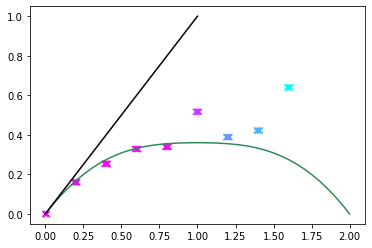

1


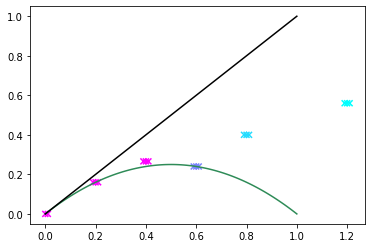

2


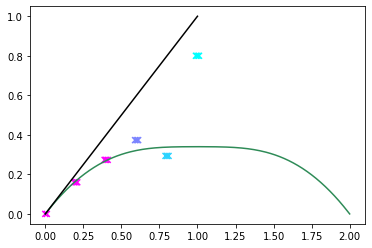

3


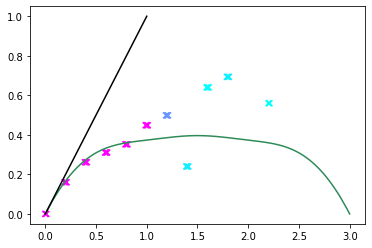

4


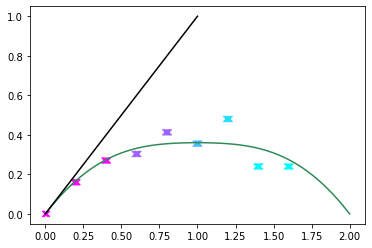

In [423]:
optimum_para = {}
optimum_para['binomial'] = [1.54, 1., 1.62, 1.90, 1.54]
stats = variance_mean(recording, t_list, optimum_para)
for cell in range(5):
    print(cell)
    plt.scatter(stats[cell]['means'], stats[cell]['variances'], c=stats[cell]['weights'], marker='x', cmap='cool', vmax=150, label='empirical')
    plt.plot(stats[cell]['means_dis'], stats[cell]['vars_dis'], '-', color='#2E8B57', label='binomial')
    plt.plot([0, 1], [0, 1], 'k')
    plt.show()

In [3]:
device = torch.device('cuda:6')
cfg = get_custom_cfg('bn_cnn_stack')
model = select_model(cfg, device)
checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_045_loss_-3.65_pearson_0.6503.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
test_data = DataLoader(TestDataset(cfg), batch_size=500)
test_pc, pred, targ = pearsonr_batch_eval(model, test_data, 5, device, cfg)

KeyError: 'bn_cnn_stack'

In [237]:
from torchdeepretina.utils import inspect
testset = TestDataset(cfg)
X = torch.from_numpy((testset.X.astype('float32') - testset.stats['mean']) / testset.stats['std'])
output = inspect(model, X.to(device), ['bipolar.2', 'amacrine.3'])
np.abs(X).mean(), np.abs(output['bipolar.2']).mean(), np.abs(output['amacrine.3']).mean()

(tensor(0.7292), 0.061888248, 0.062584065)

In [471]:
for seed in range(100):
    binomial_para = [1.54, 1., 1.62, 1.90, 1.54]
    t_list = [3,2,3,4,3]
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 5, [0., 0.78, 0, 0], seed=seed)
    poly_paras = poly_para_fit(recording, pred_single_trial_pre, t_list)
    pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=500, thre=9, seed=seed)

    min_error = 10
    for i in range(500):
        pred_single_trial = pred_single_trial_multi[i]
        error, error_stim, error_noise = error_corr3(single_trial_bin, pred_single_trial, 15)
        if error < min_error:
            min_error = error
            min_error_stim = error_stim
            min_error_noise = error_noise
    print(seed, min_error_noise, min_error_stim)

0 0.0018172869748861583 0.00697016850762525
1 0.0007248197967212793 0.010249839443528367
2 0.002091981391178906 0.00872014999796484
3 0.001079609571983047 0.012966318538438815
4 0.0014024498210902776 0.00614029171935165
5 0.0015762671538950448 0.008305935276807938
6 0.0020526753621312906 0.011199580338055291
7 0.001587985574810338 0.006785455727619766
8 0.0011619593190096299 0.014045529438296282
9 0.0015657857961848117 0.00978612030444308
10 0.001187139663579594 0.01519292787381644
11 0.001966590827818986 0.008741514817917491
12 0.0009224451508284487 0.011111363996480637
13 0.0013267244154785433 0.017067448907917105
14 0.0011331266969461804 0.013136870924269288
15 0.001120985896471511 0.00989377233120424
16 0.0011860406170058045 0.010560279366279717
17 0.001108091972588382 0.013030113215758487
18 0.0013239830792846693 0.010614776724903886
19 0.0010742231640229482 0.012922334117322635
20 0.0007936781526808425 0.011274506627873047
21 0.0014160860125024507 0.008669361697318212
22 0.001469

In [445]:
binomial_para = [1.54, 1., 1.62, 1.90, 1.54]
t_list = [3,2,3,4,3]
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 5, [0., 0, 1.2, 0])
poly_paras = poly_para_fit(recording, pred_single_trial_pre, t_list)
pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=500, seed=None, thre=0)
for thre in np.arange(8, 15, 0.5):
    pred_single_trial_multi[:, :, pred<thre] = 0
    min_error = 10
    for i in range(500):
        pred_single_trial = pred_single_trial_multi[i]
        error = error_corr2(single_trial_bin, pred_single_trial)
        if error < min_error:
            min_error = error
            pred_single_trial_try = pred_single_trial

    print(thre, variability_error(single_trial_bin, pred_single_trial_try))

8.0 0.5393372836169584
8.5 0.4745991539500062
9.0 0.46881922370787404
9.5 0.7834801901568245
10.0 0.7561575450159348
10.5 0.8690876702757043
11.0 0.90370531437361
11.5 0.6863827776908525
12.0 0.966110775437274
12.5 0.9273122088574081
13.0 1.1164801114143552
13.5 1.1285322312025479
14.0 0.9870863091241979
14.5 0.9860860587491787


In [437]:
g2_errors = []
g1_errors = []
g0_errors = []

t_list = [3,2,3,4,3]

for g2 in np.linspace(0., 1., 101):
    binomial_para = [1.54, 1., 1.62, 1.90, 1.54]
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 5, [0, 0, g2, 0])
    poly_paras = poly_para_fit(recording, pred_single_trial_pre, t_list)
    pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=300, thre=9)
    
    min_error = 10
    
    for i in range(300):
        pred_single_trial = pred_single_trial_multi[i]
        _, stim_error, noise_error = error_corr3(single_trial_bin, pred_single_trial)
        if noise_error < min_error:
            min_error = noise_error
            min_error_stim = stim_error
         
    g2_errors.append((g2, min_error_stim, min_error))

for g1 in np.linspace(0., 0.8, 81):
    binomial_para = [1.54, 1., 1.62, 1.90, 1.54]
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 5, [0, g1, 0, 0])
    poly_paras = poly_para_fit(recording, pred_single_trial_pre, t_list)
    pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=300, thre=9)
    
    min_error = 10
    
    for i in range(300):
        pred_single_trial = pred_single_trial_multi[i]
        _, stim_error, noise_error = error_corr3(single_trial_bin, pred_single_trial)
        if noise_error < min_error:
            min_error = noise_error
            min_error_stim = stim_error
         
    g1_errors.append((g1, min_error_stim, min_error))

for g0 in np.linspace(0, 5, 51):
    binomial_para = [1.54, 1., 1.62, 1.90, 1.54]
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 5, [g0, 0, 0, 0])
    poly_paras = poly_para_fit(recording, pred_single_trial_pre, t_list)
    pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=300, thre=9)
    
    min_error = 10
    
    for i in range(300):
        pred_single_trial = pred_single_trial_multi[i]
        _, stim_error, noise_error = error_corr3(single_trial_bin, pred_single_trial)
        if noise_error < min_error:
            min_error = noise_error
            min_error_stim = stim_error
         
    g0_errors.append((g0, min_error_stim, min_error))

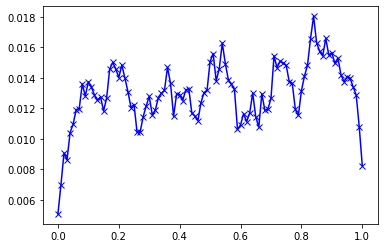

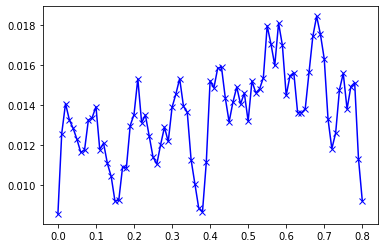

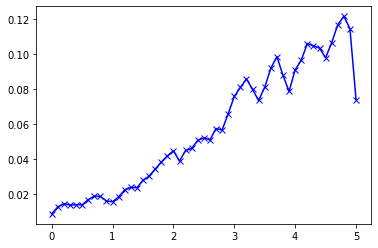

In [441]:
errors = np.convolve(np.array(g2_errors)[:, 1], np.ones(5)/5, mode='same')
plt.plot(np.array(g2_errors)[:, 0], errors, 'bx-')
plt.show()
errors = np.convolve(np.array(g1_errors)[:, 1], np.ones(5)/5, mode='same')
plt.plot(np.array(g1_errors)[:, 0], errors, 'bx-')
plt.show()
errors = np.convolve(np.array(g0_errors)[:, 1], np.ones(3)/3, mode='same')
plt.plot(np.array(g0_errors)[:, 0], errors, 'bx-')
plt.show()

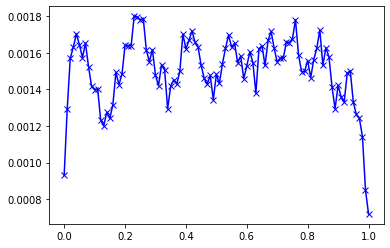

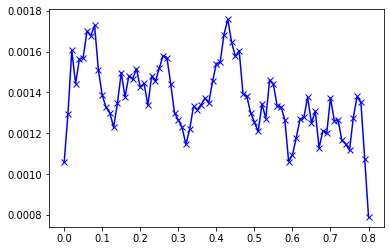

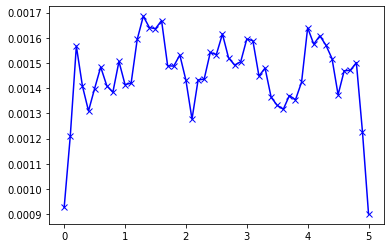

In [442]:
errors = np.convolve(np.array(g2_errors)[:, 2], np.ones(5)/5, mode='same')
plt.plot(np.array(g2_errors)[:, 0], errors, 'bx-')
plt.show()
errors = np.convolve(np.array(g1_errors)[:, 2], np.ones(5)/5, mode='same')
plt.plot(np.array(g1_errors)[:, 0], errors, 'bx-')
plt.show()
errors = np.convolve(np.array(g0_errors)[:, 2], np.ones(5)/5, mode='same')
plt.plot(np.array(g0_errors)[:, 0], errors, 'bx-')
plt.show()

In [448]:
g2_errors = []
g1_errors = []
g0_errors = []

t_list = [3,2,3,4,3]

for g2 in np.linspace(0., 3., 101):
    binomial_para = [1.54, 1., 1.62, 1.90, 1.54]
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 5, [0, 0, g2, 0])
    poly_paras = poly_para_fit(recording, pred_single_trial_pre, t_list)
    pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=300, thre=9)
    
    min_error = 10
    
    for i in range(300):
        pred_single_trial = pred_single_trial_multi[i]
        error, stim_error, noise_error = error_corr3(single_trial_bin, pred_single_trial, weight=15)
        if error < min_error:
            min_error = error
            min_error_noise = noise_error
            min_error_stim = stim_error
         
    g2_errors.append((g2, min_error_stim, min_error_noise))

for g1 in np.linspace(0., 3., 101):
    binomial_para = [1.54, 1., 1.62, 1.90, 1.54]
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 5, [0, g1, 0, 0])
    poly_paras = poly_para_fit(recording, pred_single_trial_pre, t_list)
    pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=300, thre=9)
    
    min_error = 10
    
    for i in range(300):
        pred_single_trial = pred_single_trial_multi[i]
        error, stim_error, noise_error = error_corr3(single_trial_bin, pred_single_trial, weight=15)
        if error < min_error:
            min_error = error
            min_error_noise = noise_error
            min_error_stim = stim_error
         
    g1_errors.append((g1, min_error_stim, min_error_noise))

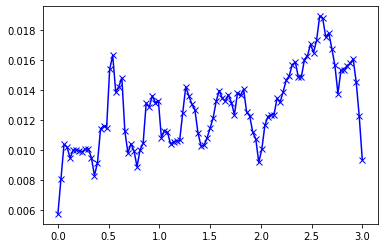

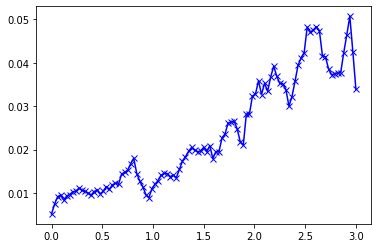

In [450]:
errors = np.convolve(np.array(g2_errors)[:, 1], np.ones(5)/5, mode='same')
plt.plot(np.array(g2_errors)[:, 0], errors, 'bx-')
plt.show()
errors = np.convolve(np.array(g1_errors)[:, 1], np.ones(5)/5, mode='same')
plt.plot(np.array(g1_errors)[:, 0], errors, 'bx-')
plt.show()

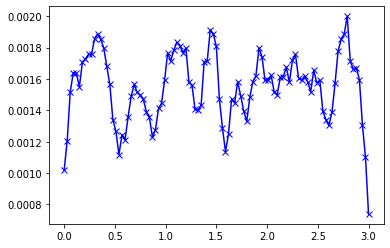

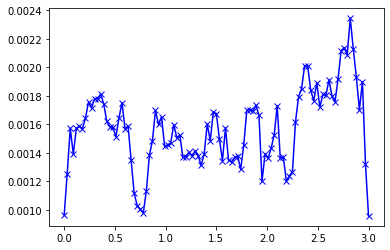

In [451]:
errors = np.convolve(np.array(g2_errors)[:, 2], np.ones(5)/5, mode='same')
plt.plot(np.array(g2_errors)[:, 0], errors, 'bx-')
plt.show()
errors = np.convolve(np.array(g1_errors)[:, 2], np.ones(5)/5, mode='same')
plt.plot(np.array(g1_errors)[:, 0], errors, 'bx-')
plt.show()

In [466]:
np.array(g1_errors)[:, 0][24]

0.72

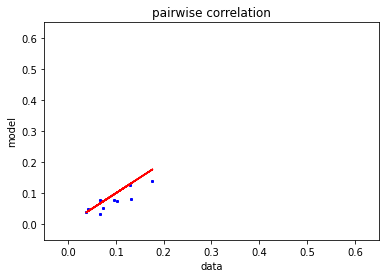

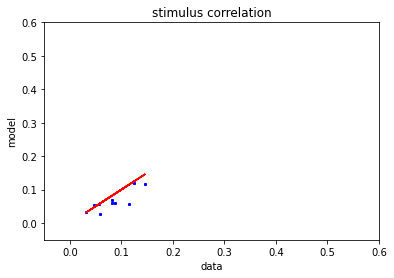

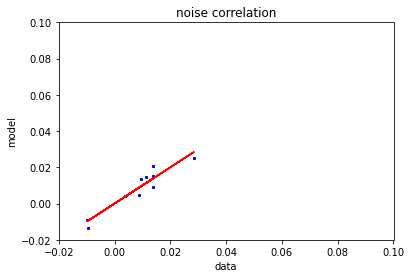

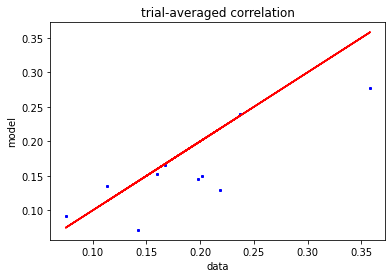

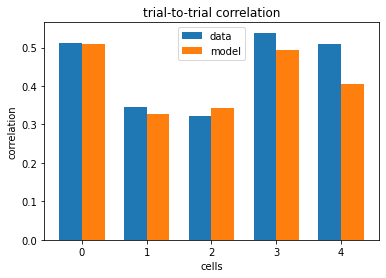

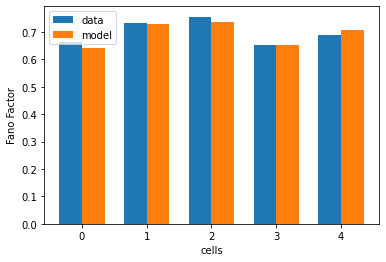

0.0002825161576574486


In [447]:
binomial_para = [1.54, 1., 1.62, 1.90, 1.54]
t_list = [3,2,3,4,3]
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 5, [0., 0, 1.2, 0], seed=23)
poly_paras = poly_para_fit(recording, pred_single_trial_pre, t_list)
pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=500, thre=9, seed=23)

min_error = 10
for i in range(500):
    pred_single_trial = pred_single_trial_multi[i]
    error = error_corr2(single_trial_bin, pred_single_trial)
    if error < min_error:
        min_error = error
        pred_single_trial_try = pred_single_trial
        
correlation_plot_2(single_trial_bin, pred_single_trial_try)
print(min_error)

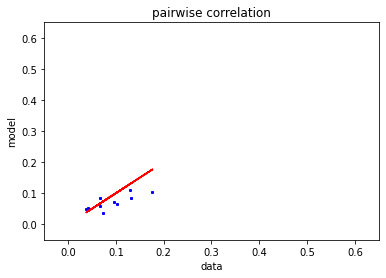

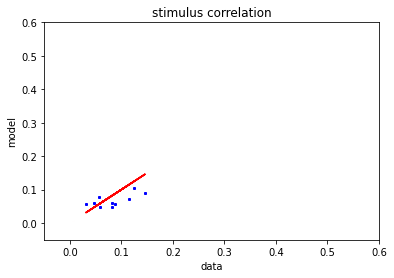

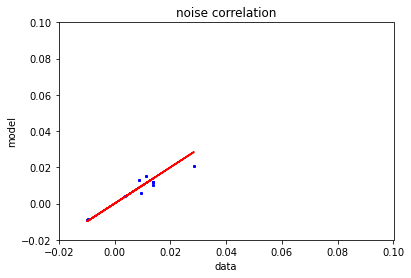

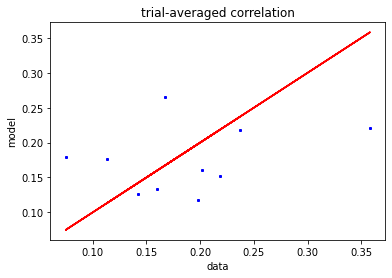

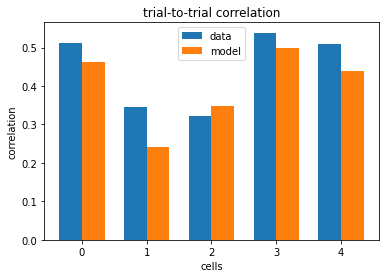

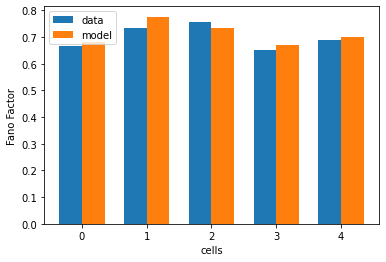

0.00027283460842685773


In [469]:
binomial_para = [1.54, 1., 1.62, 1.90, 1.54]
t_list = [3,2,3,4,3]
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 5, [0., 0.78, 0., 0], seed=68)
poly_paras = poly_para_fit(recording, pred_single_trial_pre, t_list)
pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=500, thre=9, seed=68)

min_error = 10
for i in range(500):
    pred_single_trial = pred_single_trial_multi[i]
    error = error_corr2(single_trial_bin, pred_single_trial)
    if error < min_error:
        min_error = error
        pred_single_trial_try = pred_single_trial
        
correlation_plot_2(single_trial_bin, pred_single_trial_try)
print(min_error)

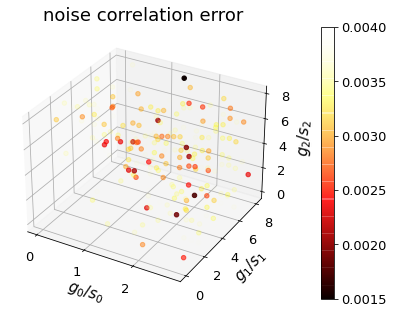

In [313]:
cmap = pl.cm.hot
my_cmap = cmap(np.arange(cmap.N))
my_cmap[:,-1] = np.linspace(1, 0, cmap.N)
my_cmap = ListedColormap(my_cmap)

g0s = []
g1s = []
g2s = []
errors =[]
f = open('./errors_15-10-07.txt', 'r')
for line in f.readlines():
    g0 = round(float(line.split()[0][1:-1]), 3)
    g1 = round(float(line.split()[1][:-1]), 3)
    g2 = round(float(line.split()[2][:-1]), 3)
    error = float(line.split()[3])
    g0s.append(g0)
    g1s.append(g1)
    g2s.append(g2)
    errors.append(error)
g0s = np.array(g0s)/0.729
g1s = np.array(g1s)/0.0619
g2s = np.array(g2s)/0.0626
errors = np.array(errors)

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(projection='3d')
p = ax.scatter(g0s, g1s, g2s, c=errors, marker='o', cmap=my_cmap, vmax=0.004, vmin=0.0015, depthshade=False)
ax.set_xlabel(r'$g_0/s_0$', fontsize=15)
ax.set_ylabel(r'$g_1/s_1$', fontsize=15)
ax.set_zlabel(r'$g_2/s_2$', fontsize=15)
ax.set_title('noise correlation error', fontsize=18)
cbar = fig.colorbar(p, ax=ax)
plt.locator_params(nbins=5)
ax.tick_params(axis='both', which='major', labelsize=13)
cbar.ax.tick_params(labelsize=13)
#plt.savefig('/home/xhding/workspaces/torch-deep-retina/fnn/notebook/figs/3d.png', dpi=300, bbox_inches = "tight")
plt.show()

### New Polyfit

In [9]:
device = torch.device('cuda:6')
cfg = get_custom_cfg('bn_cnn_stack_15-10-07')
model_func = getattr(models, cfg.Model.name)
model_kwargs = dict(cfg.Model)
model = model_func(**model_kwargs).to(device)
checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_045_loss_-3.65_pearson_0.6503.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
test_data = DataLoader(TestDataset(cfg), batch_size=500)
test_pc, pred, targ = pearsonr_batch_eval(model, test_data, 5, device)

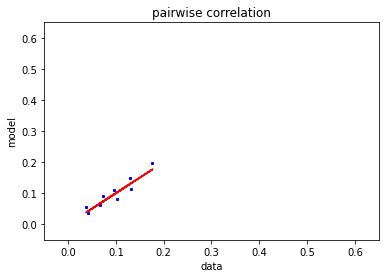

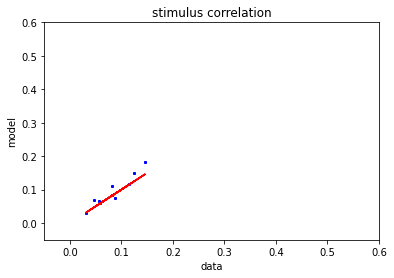

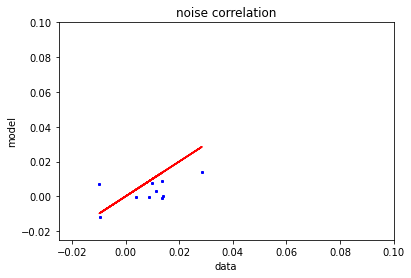

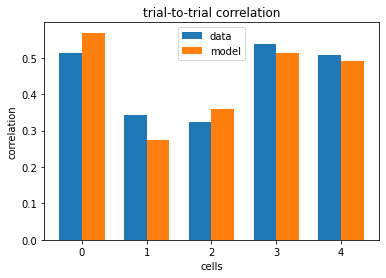

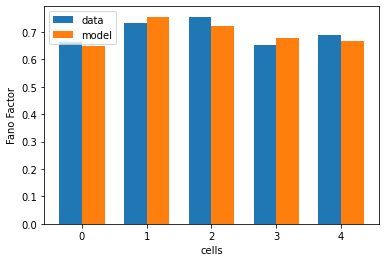

0.0022419993612737043


In [25]:
binomial_para = [1.54, 1., 1.62, 1.90, 1.54]
t_list = [3,2,3,4,3]

poly_paras = poly_para_fit(recording, np.tile(pred, (5, 1, 1)), pred, thre=1, threshold=0.4, intv=0.2, sigma=True)
pred_single_trial_multi = model_single_trial_post_multi(np.tile(pred, (5, 1, 1)), binomial_para, t_list, poly_paras, pred, n_repeats=10, seed=None, thre=1)

min_error = 10
for i in range(10):
    pred_single_trial = pred_single_trial_multi[i]
    error = error_corr2(single_trial_bin, pred_single_trial)
    if error < min_error:
        min_error = error
        pred_single_trial_try = pred_single_trial
        
correlation_plot_2(single_trial_bin, pred_single_trial_try)
print(min_error)

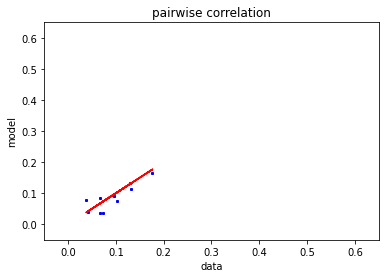

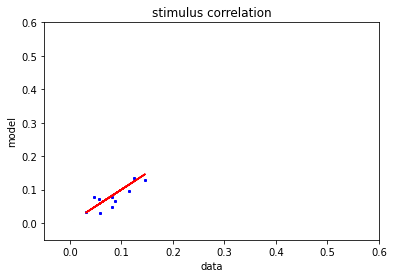

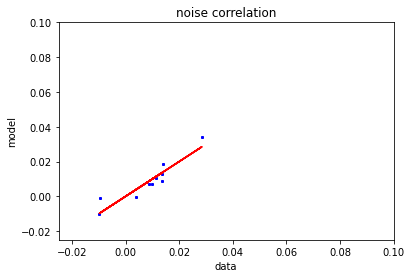

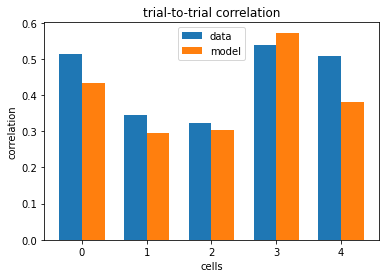

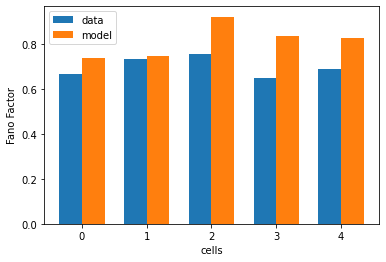

0.014261303811773441


In [104]:
binomial_para = [1.54, 1., 1.62, 1.90, 1.54]
t_list = [3,2,3,4,3]

pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 5, [0., 0., 0.5, 0.], seed=86)
poly_paras = poly_para_fit(recording, pred_single_trial_pre, pred, thre=1, threshold=0.4, intv=0.2, sigma=False)
pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=300, seed=86, thre=1)

min_error = 10
for i in range(300):
    pred_single_trial = pred_single_trial_multi[i]
    error, stim_error, noise_error = error_corr3(single_trial_bin, pred_single_trial, weight=15)
    if error < min_error:
        min_error = error
        pred_single_trial_try = pred_single_trial
        
correlation_plot_2(single_trial_bin, pred_single_trial_try)
print(min_error)

In [105]:
single_trial_bin.sum(), pred_single_trial_try.sum()

(3573.0, 3368)

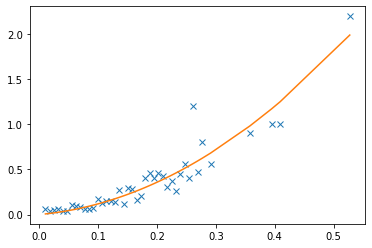

In [102]:
def poly(x,c,d):
        return c*x**2+d*x
    
cell = 3
means = []
rates = []
sigmas = []

pred_single_trial_pre[:, pred<1] = 0

for rate in np.linspace(0.3, pred_single_trial_pre.mean(0)[:, cell].max(), 100):
    mean, var, _, w = recording.stats_rate(pred_single_trial_pre.mean(0), cell=cell, rate=rate, intv=0.2)
    if var > 0:
        sigmas.append(np.sqrt(var/(w-1)))
        means.append(mean)
        rates.append(rate/100)
sigmas = np.array(sigmas)[~np.isnan(means)]
rates = np.array(rates)[~np.isnan(means)]
means = np.array(means)[~np.isnan(means)]

max_idx = np.where(means >= 0.8*means.max())[0][-1]
min_idx = np.where(rates == rates.min())[0][0]
slope = (means[max_idx] -  means[min_idx]) / (rates[max_idx] -  rates[min_idx])
means_res = means - (rates - rates[min_idx]) * slope - means[min_idx]
valid_idx = np.where(np.abs(means_res/means[max_idx]) < 0.4)

rates = rates[valid_idx]
means = means[valid_idx]
sigmas = sigmas[valid_idx]

para = curve_fit(poly, rates, means)[0]

plt.plot(rates, means, 'x')
plt.plot(rates, [poly(rates[i], *para) for i in range(len(rates))])

In [106]:
g2_errors = []
g1_errors = []
g0_errors = []

t_list = [3,2,3,4,3]

for g2 in np.linspace(0., 1., 51):
    binomial_para = [1.54, 1., 1.62, 1.90, 1.54]
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 5, [0, 0, g2, 0])
    poly_paras = poly_para_fit(recording, pred_single_trial_pre, pred, thre=1, threshold=0.4, intv=0.2, sigma=False)
    pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=300, thre=1)
    
    min_error = 10
    
    for i in range(300):
        pred_single_trial = pred_single_trial_multi[i]
        error, stim_error, noise_error = error_corr3(single_trial_bin, pred_single_trial, weight=15)
        if error < min_error:
            min_error = error
            min_error_stim = stim_error
            min_error_noise = noise_error
         
    g2_errors.append((g2, min_error_stim, min_error_noise))

for g1 in np.linspace(0., 1., 51):
    binomial_para = [1.54, 1., 1.62, 1.90, 1.54]
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 5, [0, g1, 0, 0])
    poly_paras = poly_para_fit(recording, pred_single_trial_pre, pred, thre=1, threshold=0.4, intv=0.2, sigma=False)
    pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=300, thre=1)
    
    min_error = 10
    
    for i in range(300):
        pred_single_trial = pred_single_trial_multi[i]
        error, stim_error, noise_error = error_corr3(single_trial_bin, pred_single_trial, weight=15)
        if error < min_error:
            min_error = error
            min_error_stim = stim_error
            min_error_noise = noise_error
         
    g1_errors.append((g1, min_error_stim, min_error_noise))

for g0 in np.linspace(0, 3, 51):
    binomial_para = [1.54, 1., 1.62, 1.90, 1.54]
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 5, [g0, 0, 0, 0])
    poly_paras = poly_para_fit(recording, pred_single_trial_pre, pred, thre=1, threshold=0.4, intv=0.2, sigma=False)
    pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=300, thre=1)
    
    min_error = 10
    
    for i in range(300):
        pred_single_trial = pred_single_trial_multi[i]
        error, stim_error, noise_error = error_corr3(single_trial_bin, pred_single_trial, weight=15)
        if error < min_error:
            min_error = error
            min_error_stim = stim_error
            min_error_noise = noise_error
         
    g0_errors.append((g0, min_error_stim, min_error_noise))

Stimulus correlation


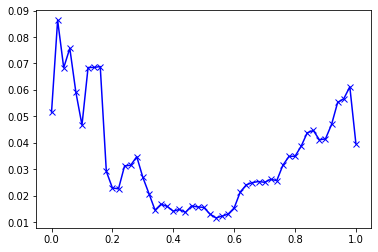

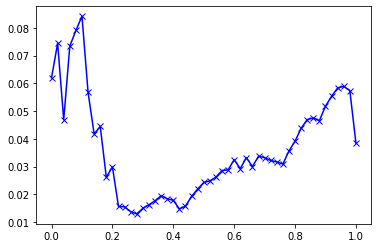

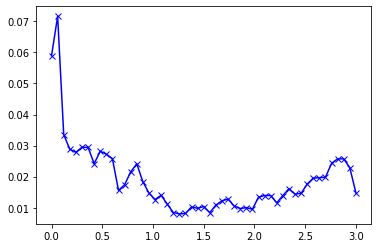

Noise correlation


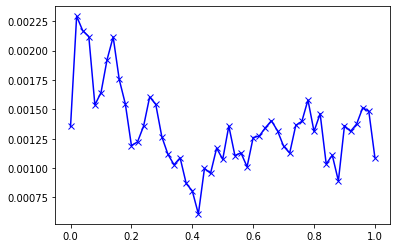

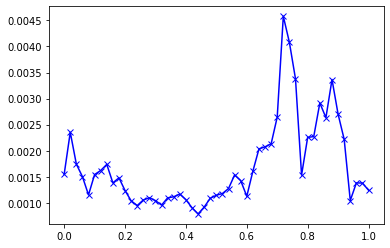

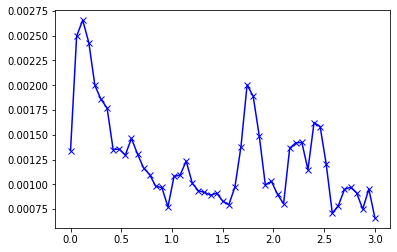

In [108]:
print("Stimulus correlation")
errors = np.convolve(np.array(g2_errors)[:, 1], np.ones(3)/3, mode='same')
plt.plot(np.array(g2_errors)[:, 0], errors, 'bx-')
plt.show()
errors = np.convolve(np.array(g1_errors)[:, 1], np.ones(3)/3, mode='same')
plt.plot(np.array(g1_errors)[:, 0], errors, 'bx-')
plt.show()
errors = np.convolve(np.array(g0_errors)[:, 1], np.ones(3)/3, mode='same')
plt.plot(np.array(g0_errors)[:, 0], errors, 'bx-')
plt.show()
print("Noise correlation")
errors = np.convolve(np.array(g2_errors)[:, 2], np.ones(3)/3, mode='same')
plt.plot(np.array(g2_errors)[:, 0], errors, 'bx-')
plt.show()
errors = np.convolve(np.array(g1_errors)[:, 2], np.ones(3)/3, mode='same')
plt.plot(np.array(g1_errors)[:, 0], errors, 'bx-')
plt.show()
errors = np.convolve(np.array(g0_errors)[:, 2], np.ones(3)/3, mode='same')
plt.plot(np.array(g0_errors)[:, 0], errors, 'bx-')
plt.show()

In [30]:
for seed in range(100):
    binomial_para = [1.54, 1., 1.62, 1.90, 1.54]
    t_list = [3,2,3,4,3]

    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 5, [0., 0., 0.42, 0.], seed=seed)
    poly_paras = poly_para_fit(recording, pred_single_trial_pre, pred, thre=1, threshold=0.4, intv=0.2, sigma=False)
    pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=300, seed=seed, thre=1)

    min_error = 10
    for i in range(300):
        pred_single_trial = pred_single_trial_multi[i]
        error, stim_error, noise_error = error_corr3(single_trial_bin, pred_single_trial, weight=1/15)
        if error < min_error:
            min_error = error
    print(seed, min_error)

0 0.0023187634569605217
1 0.002020665202087818
2 0.0021578804396781945
3 0.0017087096707898999
4 0.001375090637917093
5 0.001933276513563083
6 0.0014358752098594598
7 0.0017476604010295432
8 0.0019840886796871535
9 0.0018031602349308578
10 0.002678760399909277
11 0.002079450689106947
12 0.002186678397411641
13 0.0018094312762079042
14 0.0020599272889767657
15 0.001807701550395594
16 0.0011652244381292086
17 0.0020151810308742333
18 0.0017287659477291974
19 0.0013599184755836344
20 0.002153929864263735
21 0.0014020073243789814
22 0.0012539320762167423
23 0.0019739324233653257
24 0.0026071000898960977
25 0.0027041085765782177
26 0.0014692804355544648
27 0.002458696226332041
28 0.0015292665689572284
29 0.0024575296735978433
30 0.0013376793627436498
31 0.0015011400626332779
32 0.0018601640044791292
33 0.0013808297731196717
34 0.0017543435459963486
35 0.002108115852784564
36 0.001683663162220945
37 0.001596145609250698
38 0.00239588724569557
39 0.001977903292822194
40 0.0020209200476700518


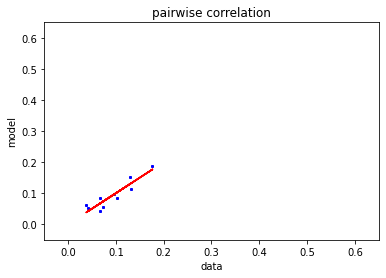

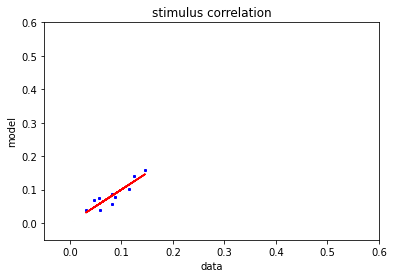

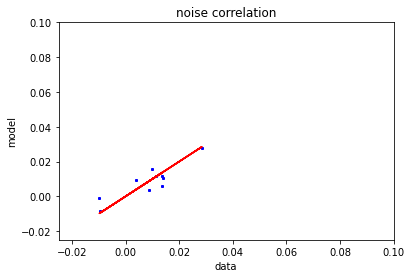

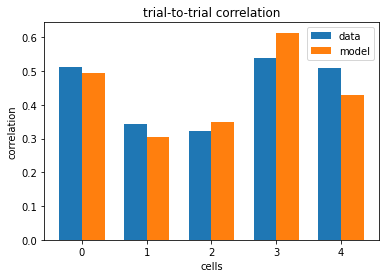

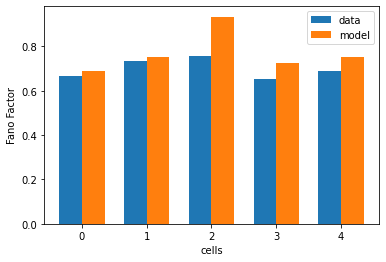

0.0008723542484175405


In [6]:
binomial_para = [1.54, 1., 1.62, 1.90, 1.54]
t_list = [3,2,3,4,3]

pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 5, [0., 0., 0.42, 0.], seed=86)
poly_paras = poly_para_fit(recording, pred_single_trial_pre, pred, thre=1, threshold=0.4, intv=0.2, sigma=False)
pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=300, seed=86, thre=1)

min_error = 10
for i in range(300):
    pred_single_trial = pred_single_trial_multi[i]
    error, stim_error, noise_error = error_corr3(single_trial_bin, pred_single_trial, weight=1/15)
    if error < min_error:
        min_error = error
        min_stim_error = stim_error
        min_noise_error = noise_error
        pred_single_trial_try = pred_single_trial
        
correlation_plot_2(single_trial_bin, pred_single_trial_try)
print(min_error)

In [6]:
path = "./response_dict.npy"
date = "15-10-07"
data = response_dict(path, date, single_trial_bin, pred_single_trial_try)

In [41]:
print(min_stim_error, min_noise_error)

0.005421017510944014 0.0005109530810212729


In [11]:
testset = TestDataset(cfg)
X = torch.from_numpy((testset.X.astype('float32') - testset.stats['mean']) / testset.stats['std'])
output = inspect(model, X.to(device), ['bipolar.2', 'amacrine.3'])
s0 = np.abs(X).numpy().mean()
s1 = np.abs(output['bipolar.2']).mean()
s2 = np.abs(output['amacrine.3']).mean()
print((s0, s1, s2))

(0.72922426, 0.061888248, 0.062584065)


In [6]:
g0s, g1s, g2s, stim_errors, noise_errors, var_errors = read_search_result('./errors_15-10-07.txt')

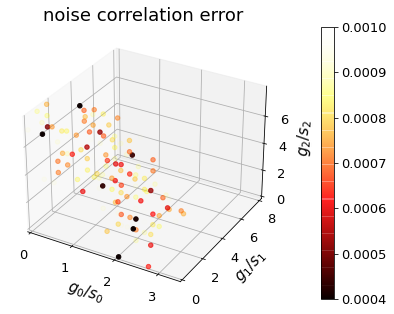

In [7]:
scatter_plot(g0s, g1s, g2s, stim_errors, noise_errors, var_errors, s0, s1, s2, noise_thre=0.001, stim_thre=0.015, var_thre=1.5, vmin=0.0004)

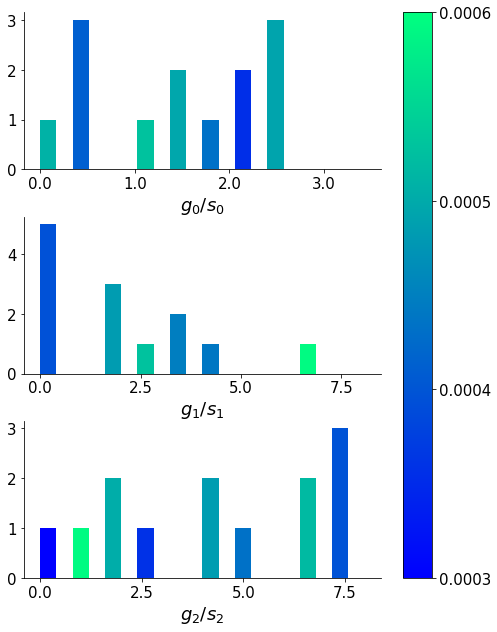

In [8]:
marginal_histogram(g0s, g1s, g2s, stim_errors, noise_errors, var_errors, s0, s1, s2, noise_thre=0.0006, stim_thre=0.015, var_thre=1.5, vmin=0.0003)

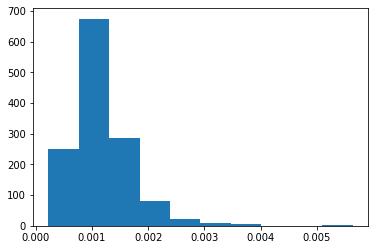

In [48]:
plt.hist(noise_errors)
plt.show()

In [10]:
from torchdeepretina.utils import compute_sta
from pyret.filtertools import decompose

num_cells = 5

centers = []
for cell in range(num_cells):
    sta = compute_sta(model, 1, "ganglion", cell, verbose=False)
    s, _ = decompose(sta)
    center = np.where(np.abs(s) == np.abs(s).max())
    centers.append((center[0][0], center[1][0]))

def dist(a, b):
    return np.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)

dists = []
for i in range(num_cells):
    for j in range(i+1, num_cells):
        dists.append(dist(centers[i], centers[j]))
dists = np.array(dists)

print(dists.max(), dists.mean())

11.045361017187261 5.707554090437206
